In [1]:
from CasingSimulations import * 
%matplotlib inline

In [2]:
directory = 'CasingStump'
cpfile = "CasingProperties.json"
resultsfile = "CasingStump.hdf5"
rerun = False

# Model Parameters

In [3]:
cp_file = '{directory}/{cpfile}'.format(directory=directory, cpfile=cpfile)

if rerun is True:
    cp = CasingProperties(muModels=[50.], casing_l=100., casing_top=-900.)
else:
    with open(cp_file, 'r') as outfile:
        cp = CasingProperties.deserialize(json.load(cp_file))

In [5]:
# src_a = np.r_[0., 0., dsz]
# casing_r = casing_d/2.
# casing_a = casing_r - casing_t/2.  # inner radius
# casing_b = casing_r + casing_t/2.  # outer radius
# casing_z = np.r_[-casing_l, 0.] + casing_top

In [6]:
# cp = CasingProperties()
# cp.serialize()

In [7]:
# # -------------- Mesh Parameters ------------------ #
# # x-direction
# csx1, csx2 = 2.5e-3, 25.  # fine cells near well bore
# pfx1, pfx2 = 1.3, 1.5  # padding factors: fine -> uniform
# ncx1 = np.ceil(casing_b/csx1+2)  # number of fine cells
#                                       # (past casing wall)
# dx2 = 1000.  # uniform mesh out to here
# npadx2 = 23  # padding out to infinity

# # z-direction
# csz = 0.05  # finest z-cells
# nza = 10  # number of fine cells above air-earth interface
# pfz = pfx2 # padding factor in z-direction

# # ------------- Assemble the Cyl Mesh ------------- #
# # pad nicely to second cell size
# npadx1 = np.floor(np.log(csx2/csx1) / np.log(pfx1))
# hx1a = Utils.meshTensor([(csx1, ncx1)])
# hx1b = Utils.meshTensor([(csx1, npadx1, pfx1)])
# dx1 = sum(hx1a)+sum(hx1b)
# dx1 = np.floor(dx1/csx2)
# hx1b *= (dx1*csx2 - sum(hx1a))/sum(hx1b)

# # second chunk of mesh
# ncx2 = np.ceil((dx2 - dx1)/csx2)
# hx2a = Utils.meshTensor([(csx2, ncx2)])
# hx2b = Utils.meshTensor([(csx2, npadx2, pfx2)])
# hx = np.hstack([hx1a, hx1b, hx2a, hx2b])

# # cell size, number of core cells, number of padding cells in the
# # x-direction
# ncz = np.int(np.ceil(-casing_z[0]/csz))+10
# npadzu, npadzd = 38, 38

# # vector of cell widths in the z-direction
# hz = Utils.meshTensor(
#         [(csz, npadzd, -pfz), (csz, ncz), (csz, npadzu, pfz)]
#         )

# # primary mesh
# mesh = Mesh.CylMesh(
#     [hx, 1., hz], [0., 0., -np.sum(hz[:npadzu+ncz-nza])]
#     )

# print(
#     'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
#         mesh.vectorCCx.max(),
#         mesh.vectorCCz.min(),
#         mesh.vectorCCz.max()
#     )
# )

# print(mesh.nC)
# print([500./np.sqrt(sigmaback*f) for f in freqs])
# print([500./np.sqrt(sigmacasing*f) for f in freqs])

In [8]:
mesh = CasingMesh(cp).mesh

# plot model

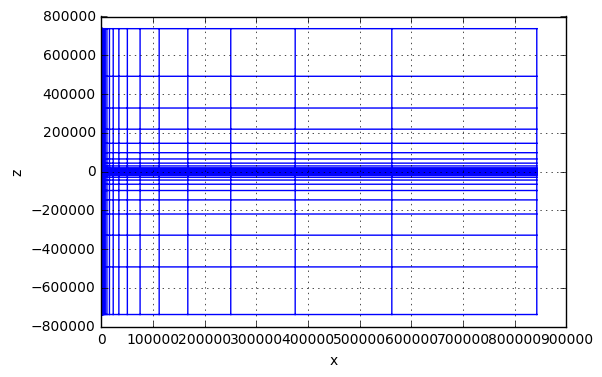

In [9]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

fig.savefig('{}/{}'.format(directory, 'CylMesh.png'))

In [10]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(cp.sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

In [11]:
mucasing = cp.muModels[0]
sigma_m = np.r_[
    np.log(cp.sigmaback), np.log(cp.sigmalayer), np.log(cp.sigmacasing), np.log(cp.sigmainside),
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, mucasing*mu_0, mu_0,
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

In [12]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 23.4 s, sys: 523 ms, total: 24 s
Wall time: 24.3 s


In [13]:
casingMap.mDict(sigma_m)

{u'casing_bottom': -1000.0,
 u'casing_radius': 0.050000000000000003,
 u'casing_thickness': 0.01,
 u'casing_top': -900.0,
 u'layer_center': -950.0,
 u'layer_thickness': 100.0,
 u'val_background': -4.6051701859880909,
 u'val_casing': 15.520258650202699,
 u'val_insideCasing': 0.0,
 u'val_layer': -4.6051701859880909}

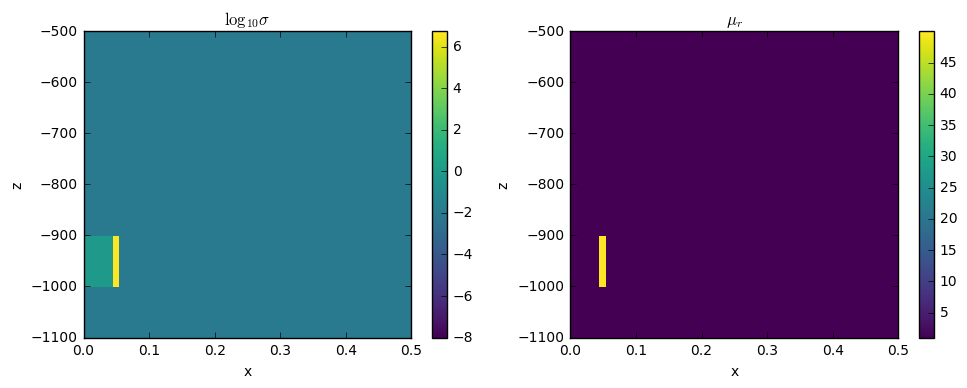

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = plotModels(mesh, sigma, mu, xlim=[0.,0.5], zlim=[-1100., -500.], ax=ax)
# fig.savefig('{}/{}'.format(directory, 'PhysPropModels'))

# Set up the Source

In [15]:
dhSrc = DownHoleCasingSrc(mesh, cp.src_a, cp.src_b, cp.casing_a, cp.freqs)

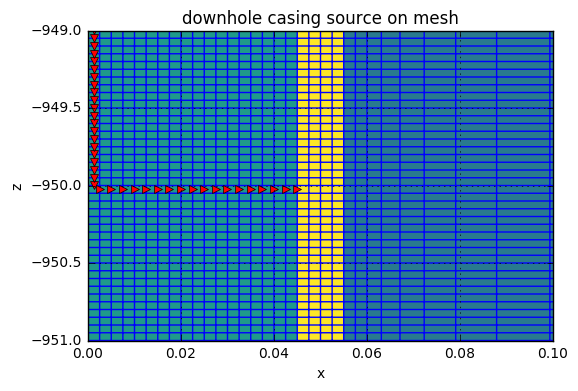

In [16]:
# Plot the source to make sure the path is infact
# connected

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
mesh.plotImage(np.log10(sigma), ax=ax)
mesh.plotGrid(ax=ax)
dhSrc.plotSrc(ax=ax)

ax.set_title('downhole casing source on mesh')

ax.set_xlim([0, 0.1])
ax.set_ylim([-951., -949.])

fig.savefig('{}/{}'.format(directory, 'SourceOnMesh.png'))

# Problem and Survey

In [17]:
prob = FDEM.Problem3D_h(mesh, sigma=sigma, muMap=muMap)
survey = FDEM.Survey(dhSrc.s_e)

prob.pair(survey)

In [18]:
def MuCasingModel(mucasing):
    return np.r_[
        mu_0, mu_0, mucasing*mu_0, mu_0,
        cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
        cp.casing_z[0], cp.casing_z[1]
    ]

In [19]:
cp.muModels = [1., 50., 100., 200.]
fields = {}

In [20]:
if rerun is True:
    # create a file to store results
    results = h5py.File("{}/{}".format(directory, resultsfile), "w")
else:
    results = h5py.File("{}/{}".format(directory, resultsfile), "r")

In [21]:
results.keys()

[]

In [22]:
%%time
for muMod in cp.muModels:
    tag = int(muMod)
    curMu = MuCasingModel(muMod)

    if rerun is True:
        print('solving mu = {}mu_0'.format(tag))
        fields[tag] = prob.fields(curMu)
        dbentry = "fields_{tag}".format(tag=tag)
        results.create_dataset(dbentry, data=fields[tag][:,'hSolution'])
        print('... saved fields_{tag}'.format(tag=tag))

    else:
        print('loading mu = {}mu_0'.format(tag))
        prob.model = curMu
        f = prob.fieldsPair(mesh, survey)
        f[:, 'hSolution'] = results['fields_{}'.format(tag)].value
        fields[tag] = f
        print('... loaded mu = {}mu_0'.format(tag))

solving mu = 1mu_0
... saved fields_1
solving mu = 50mu_0
... saved fields_50
solving mu = 100mu_0
... saved fields_100
solving mu = 200mu_0
... saved fields_200
CPU times: user 28min 33s, sys: 3min 4s, total: 31min 38s
Wall time: 20min 10s


0.0001 Hz, 1.0 mu_0


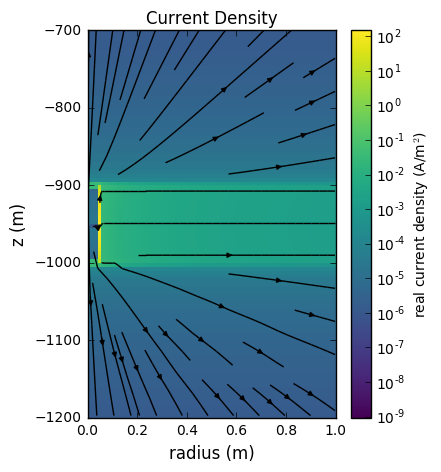

In [45]:
def vecplot_j(muind, freqind, reim='real'):
    src = survey.srcList[freqind]
    mur = cp.muModels[muind]
    
    print('{} Hz, {} mu_0'.format(cp.freqs[freqind], mur))
    plotme = getattr(fields[mur][src, 'j'], reim)
    ax = plotCurrentDensity(mesh, plotme, csx=0.005, csz=5., xmax=1., zmin=-700., zmax=-1200.)
    return ax

w = widgets.interactive(
        vecplot_j, muind=widgets.IntSlider(min=0, max=len(cp.muModels)-1),
        freqind=widgets.IntSlider(min=0, max=len(cp.freqs)-1),
        reim=widgets.ToggleButtons(options=['real', 'imag'])
)
w
#ax.axis('equal', adjustable='box')

In [24]:
# find indices where the cell centers are in the casing
casing_ind = sigma_m.copy()
casing_ind[[0, 1, 3]] = 0. # zero outside casing
casing_ind[2] = 1. # 1 inside casing 

actMap_Zeros = Maps.InjectActiveCells(mesh, indActive, 0.)

indCasing = actMap_Zeros * casingMap * casing_ind

(-1100.0, 10.0)

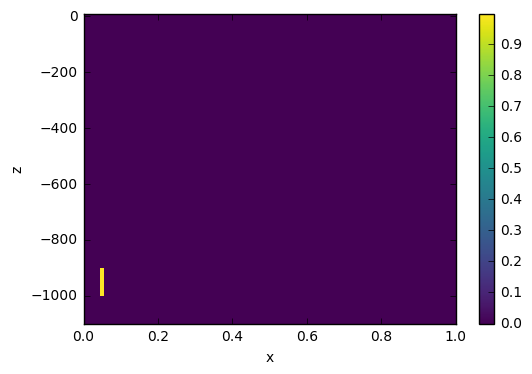

In [25]:
# plot to sanity-check
fig, ax = plt.subplots(1,1)
f = mesh.plotImage(indCasing, ax=ax)
plt.colorbar(f[0])
ax.set_xlim([0., 1.])
ax.set_ylim([-1100., 10.])

In [26]:
mur = 100
j = fields[mur][:,'j']
jA = Utils.sdiag(mesh.area) * j

print jA.shape

(4901106, 6)


In [27]:
casing_faces = mesh.aveF2CC.T * indCasing
casing_faces[casing_faces < 0.25] = 0

print casing_faces.nonzero()

(array([   4654,    4655,    4656, ..., 2699025, 2699026, 2699027]),)


(-950.0, -951.0)

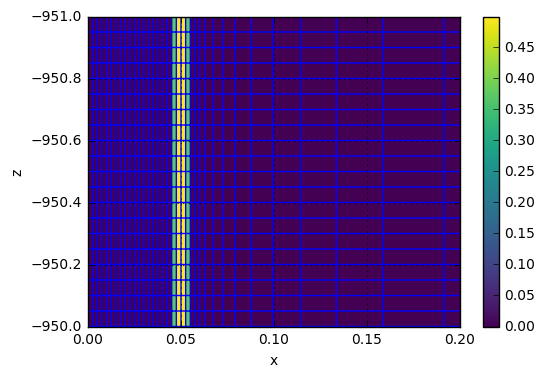

In [28]:
fig, ax = plt.subplots(1)
f = mesh.plotImage(mesh.aveF2CC * casing_faces, ax=ax)
plt.colorbar(f[0])
mesh.plotGrid(ax=ax)
ax.set_xlim([0., 0.2])
ax.set_ylim([-950., -951.])


In [33]:
IxCasing, IzCasing = CasingCurrents(cp, fields, mesh, sigma_m, indActive, casingMap)

mu = 1.0 mu_0


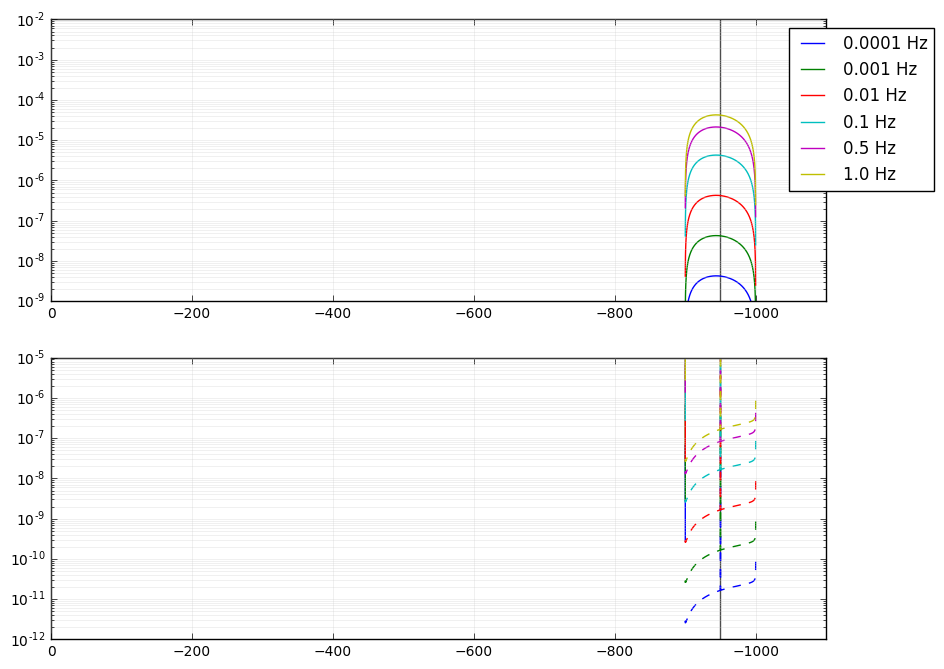

In [37]:
def plotMe_freq(muopt, reim, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    mur = cp.muModels[muopt]
    plot_currents_over_freq(IxCasing, IzCasing, cp, mesh, mur, subtract=subtract, real_or_imag=reim) #, ax=ax)  

w = widgets.interact(
    plotMe_freq, 
    muopt=widgets.IntSlider(min=0., max=len(cp.muModels)-1), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)

In [38]:
plot_currents_over_mu?

0.0001 Hz


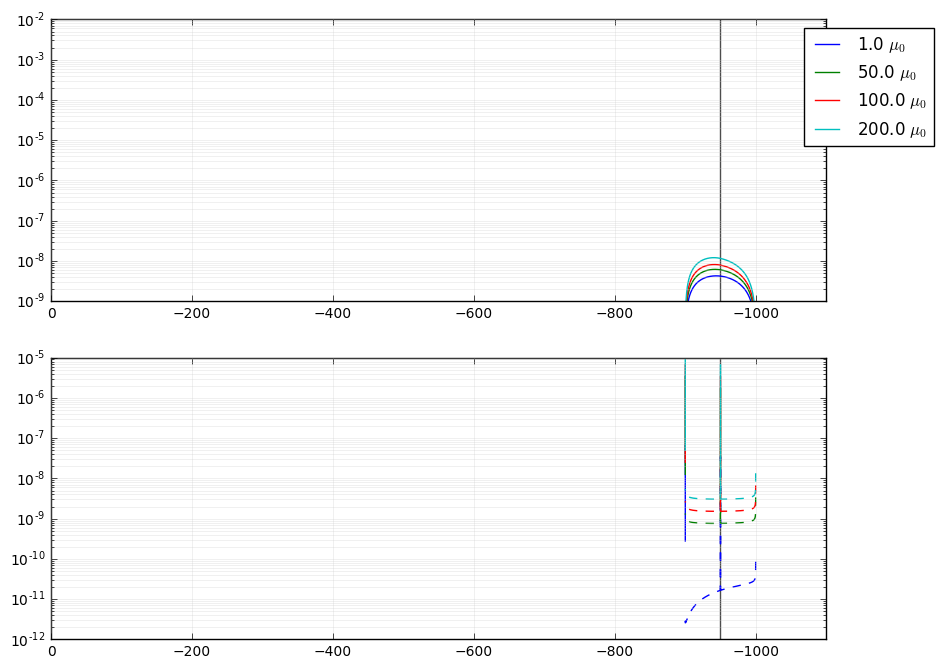

In [39]:
def plotMe_mu(freqopt, reim, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_currents_over_mu(IxCasing, IzCasing, cp, mesh, freqopt, subtract=subtract, real_or_imag=reim)  

w = widgets.interact(
    plotMe_mu, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)

w

0.0001 Hz


<function __main__.plotMe_j_mu_z>

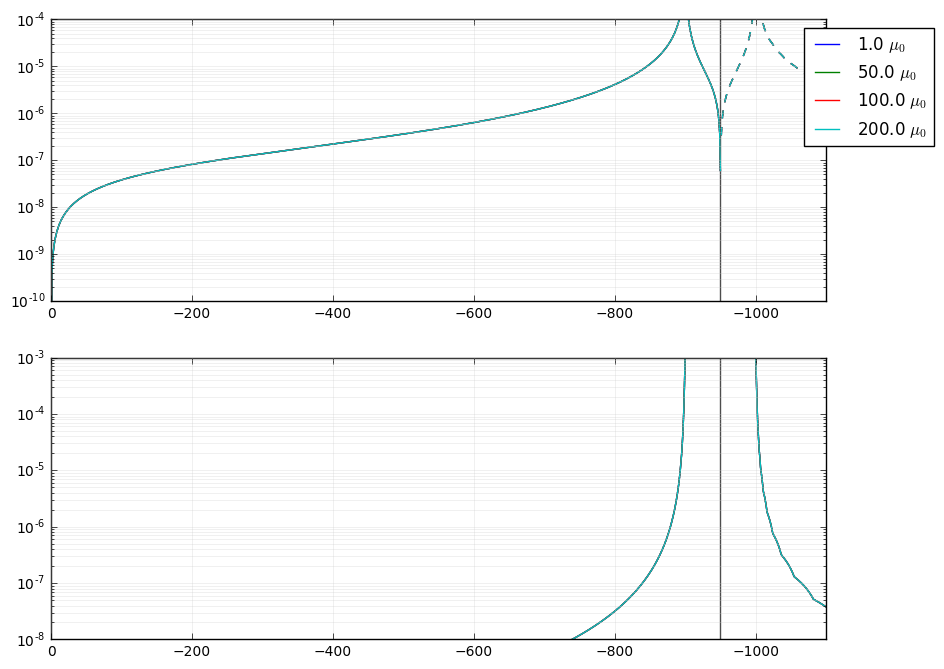

In [42]:
def plotMe_j_mu_z(freqopt, reim, r, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_j_over_mu_z(cp, fields, mesh, survey, freqopt, subtract=subtract, r=r, real_or_imag=reim)  

widgets.interact(
    plotMe_j_mu_z, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1), 
    r=widgets.FloatText(value=1.), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)

0.0001 Hz


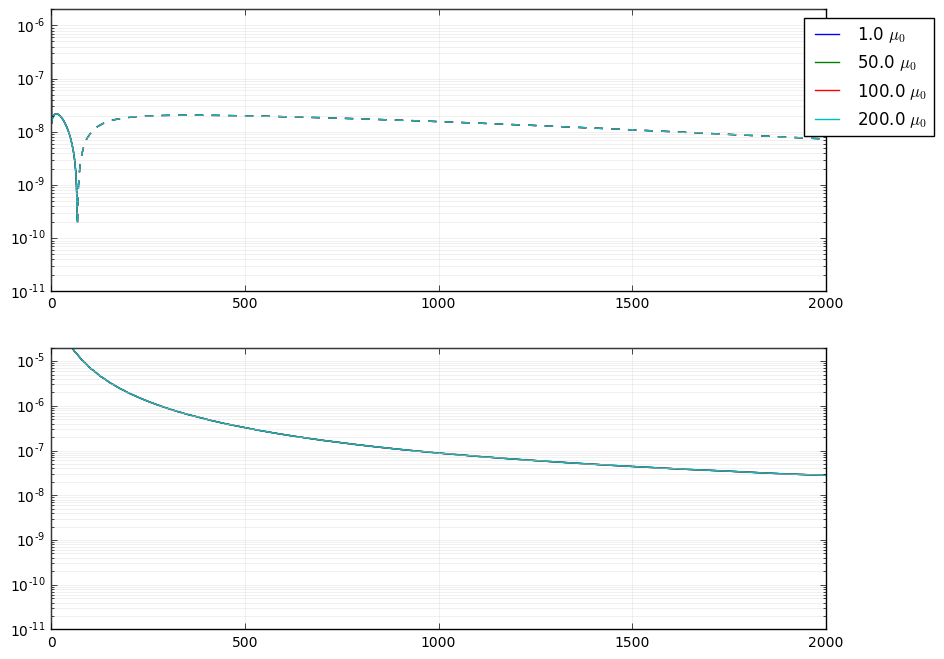

In [43]:
def plotMe_j_mu_x(freqopt, reim, z, subtract=None):
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_j_over_mu_x(cp, fields, mesh, survey, freqopt, subtract=subtract, z=z, real_or_imag=reim, ax=ax)
    plt.show()

j_over_x = widgets.interactive(
    plotMe_j_mu_x, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuous_update=False), 
    z=widgets.FloatText(value=-950., continuous_update=False), 
    subtract=widgets.ToggleButtons(options=[None, 1], continuous_update=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False)
)
j_over_x